In [2]:
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import itertools
import re
import sys
import pprint
import statistics
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy.stats import fisher_exact

module_dir = "./scripts/"
sys.path.append(module_dir)

import balticEdited as bt
# import reassortment_rates_host as rea
import reassortment_utils as rea

#use treesort_prepper to prep files and run treesort

#run before_plotting on treesort trees so then it is ready for plotting with baltic


In [3]:
def load_tree(path,filename,region_dict, host_dict):
    nwkPath=f"{path}/{filename}"
    mytree = bt.loadNewick(nwkPath, absoluteTime= False)
    mytree = traits(mytree, region_dict, host_dict)
    return(mytree)


def load_clock(blength_file):

    with open(blength_file) as f:
        data = json.load(f)

    rate = data["clock"]["rate"]
    year = data["clock"]["rtt_Tmrca"]
    
    return rate, year

def load_trait_data(traits_file):

    with open(traits_file) as f:
        data = json.load(f)
    
    region_dict = {}
    host_dict = {}

    for node_name, node_data in data['nodes'].items():
        region_dict[node_name] = node_data.get("region")
        host_dict[node_name] = node_data.get("host")

    return(region_dict, host_dict)

def traits(tree, region_dict, host_dict):
    
    for k in tree.Objects:
        if k.branchType == "node":
            k.traits["region"] = region_dict.get(k.traits["label"])
            k.traits["host"] = host_dict.get(k.traits["label"])
        if k.branchType == "leaf":
            k.traits["region"] = region_dict.get(k.name)
            k.traits["host"] = host_dict.get(k.name)
    return(tree)

In [4]:
ref = "ha"

clock_rate, root_yr = load_clock(f"./preprepped/branch-lengths_h3nx_{ref}.json")
tree_dict = {}

for i in range(1,6):
    
    path = f'trees_{i}'
    filename = 'for_plotting.nwk'
    region_dict, host_dict = load_trait_data(f"trees_{i}/traits_{i}/traits_h3nx_{ref}.json")
    mytree = load_tree(path, filename, region_dict, host_dict)
    
    tree_dict[f"trees_{i}"] = mytree


In [5]:
dates_dist = {name: [] for name in tree_dict.keys()}

for name, tree in tree_dict.items():
    
    tree.traverse_tree()  
    tree.sortBranches()
    
    leaf_heights = {}

    for leaf in tree.getExternal():
        leaf_heights[leaf.name] = (leaf.height, leaf.name.split("|")[1])
        
    dates = []
    
    for k in tree.Objects:

        # for the fisher's exact test
        if k.is_node():

            dates_and_heights = [(leaf_heights[leaf][1], leaf_heights[leaf][0]) for leaf in k.leaves]
                
            max_date, leaf_height = max(dates_and_heights, key=lambda x: x[0])
            
            date = (leaf_height - k.height) / clock_rate
            
            dates.append(date)
            
    dates_dist[name] = dates

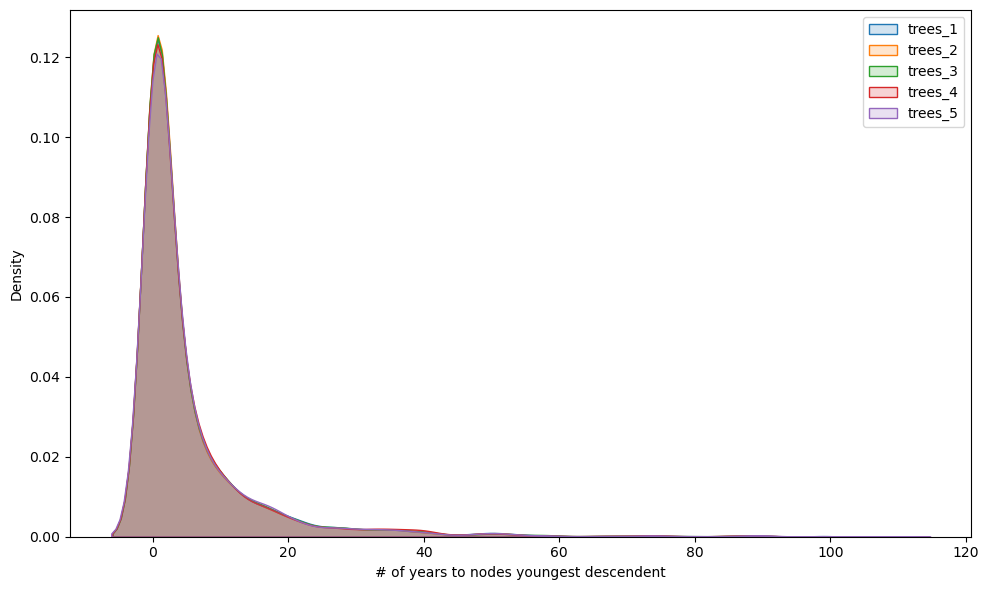

In [6]:
plt.figure(figsize=(10, 6))

for key, values in dates_dist.items():
    sns.kdeplot(values, label=key, fill=True, alpha=0.2)
    

plt.xlabel('# of years to nodes youngest descendent')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# by host 

host_order = ['Avian', 'Canine','Swine', 'Human', 'Mink', 'Seal', 'Equine', 'Camel', 'Feline']
traitName = "host"
min_leaves = 10

subtree_hosts = {name: {} for name in tree_dict.keys()}

for name, mytree in tree_dict.items():
    
    mytree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    host_trees={host:[] for host in host_order}

    for k in sorted(mytree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        # get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]   # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:  # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]     # kploc = trait of parental node
        else:
            kploc='ancestor'

        # print(k.traits)
        # print(f"kploc = {kploc}")
        # print(f"kloc = {kloc}") 

        # if states do not match
        if kloc!= "ancestor" and kloc != kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            # print('subtree resulting from '+kploc+' > '+kloc+' switch, traversing within '+ kloc)

            subtree=mytree.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                clade_leaves = [leaf for leaf in subtree.getExternal() if leaf.traits[traitName] == kloc]
                if len(clade_leaves) >= min_leaves:
                    subtree.traverse_tree()
                    subtree.sortBranches()
                    host_trees[kloc].append((kploc,subtree))
                    
        subtree_hosts[name] = host_trees


In [9]:
host_order = ['Avian', 'Canine', 'Swine', 'Human', 'Equine']

dates_dists = {name: {} for name in tree_dict.keys()}

for name, host_trees in subtree_hosts.items(): 
    
    host_dates_dists = {host:[] for host in host_order}
    
    for host, subtrees in host_trees.items():
        
        if host == "Seal" or host == "Camel" or host == "Feline" or host == "Mink":
            continue  
        
        
        dates = []
        
        for _, subtree in subtrees:
             
            if host == "Canine" and _ == "Equine":
                continue
                
            subtree.traverse_tree()  
            subtree.sortBranches()

            leaf_heights = {}

            for leaf in subtree.getExternal():
                leaf_heights[leaf.name] = (leaf.height, leaf.name.split("|")[1])
                
            for k in subtree.Objects:
                
                
                if k.is_node():

                
                    dates_and_heights = [(leaf_heights[leaf][1], leaf_heights[leaf][0]) for leaf in k.leaves]
                
                    max_date, leaf_height = max(dates_and_heights, key=lambda x: x[0])

                    date = (leaf_height - k.height) / clock_rate
                    
                    dates.append(date)
                    
        
        host_dates_dists[host] = dates
        
    dates_dist[name] = host_dates_dists
                    

## Histogram plotting

### Bin size calculations

in order to make histogram plots, you need to pick how many bins the data should be sorted into. bins all need to be the same size. they should also include outliers. there are a few ways to calculate the # of bins.  

I took the calcuations from [here](https://www.statisticshowto.com/choose-bin-sizes-statistics/) to think about what i should make the bins variable in my histogram plotting.

In [10]:
def calculate_bins(dates_dist):
    results = {}

    for tree_name, host_data in dates_dist.items():
        results[tree_name] = {}
        for host, values in host_data.items():
            data = np.array(values)
            n = len(data)

            # Square Root Rule
            sqrt_bins = int(np.sqrt(n))

            # Sturges' Rule
            sturges_bins = int(np.log2(n) + 1)

            # Rice Rule
            rice_bins = int(2 * n**(1/3))

            # Freedman-Diaconis Rule
            q25, q75 = np.percentile(data, [25, 75])
            iqr = q75 - q25
            if iqr == 0:
                fd_bins = sqrt_bins  # fallback if IQR is 0
            else:
                bin_width = 2 * iqr * n ** (-1/3)
                fd_bins = int(np.ceil((data.max() - data.min()) / bin_width))

            results[tree_name][host] = {
                "sqrt": sqrt_bins,
                "sturges": sturges_bins,
                "rice": rice_bins,
                "fd": fd_bins
            }

    return results


In [11]:
calculate_bins(dates_dist)

{'trees_1': {'Avian': {'sqrt': 48, 'sturges': 12, 'rice': 26, 'fd': 135},
  'Canine': {'sqrt': 18, 'sturges': 9, 'rice': 13, 'fd': 28},
  'Swine': {'sqrt': 44, 'sturges': 11, 'rice': 24, 'fd': 62},
  'Human': {'sqrt': 16, 'sturges': 9, 'rice': 13, 'fd': 22},
  'Equine': {'sqrt': 15, 'sturges': 8, 'rice': 12, 'fd': 18}},
 'trees_2': {'Avian': {'sqrt': 48, 'sturges': 12, 'rice': 26, 'fd': 135},
  'Canine': {'sqrt': 18, 'sturges': 9, 'rice': 13, 'fd': 28},
  'Swine': {'sqrt': 44, 'sturges': 11, 'rice': 24, 'fd': 66},
  'Human': {'sqrt': 16, 'sturges': 9, 'rice': 13, 'fd': 16},
  'Equine': {'sqrt': 15, 'sturges': 8, 'rice': 12, 'fd': 20}},
 'trees_3': {'Avian': {'sqrt': 48, 'sturges': 12, 'rice': 26, 'fd': 123},
  'Canine': {'sqrt': 18, 'sturges': 9, 'rice': 13, 'fd': 28},
  'Swine': {'sqrt': 44, 'sturges': 11, 'rice': 24, 'fd': 62},
  'Human': {'sqrt': 16, 'sturges': 9, 'rice': 13, 'fd': 16},
  'Equine': {'sqrt': 15, 'sturges': 8, 'rice': 12, 'fd': 19}},
 'trees_4': {'Avian': {'sqrt': 48,

## By host
#### histogram plot, raw counts

##### using different bin counts per host

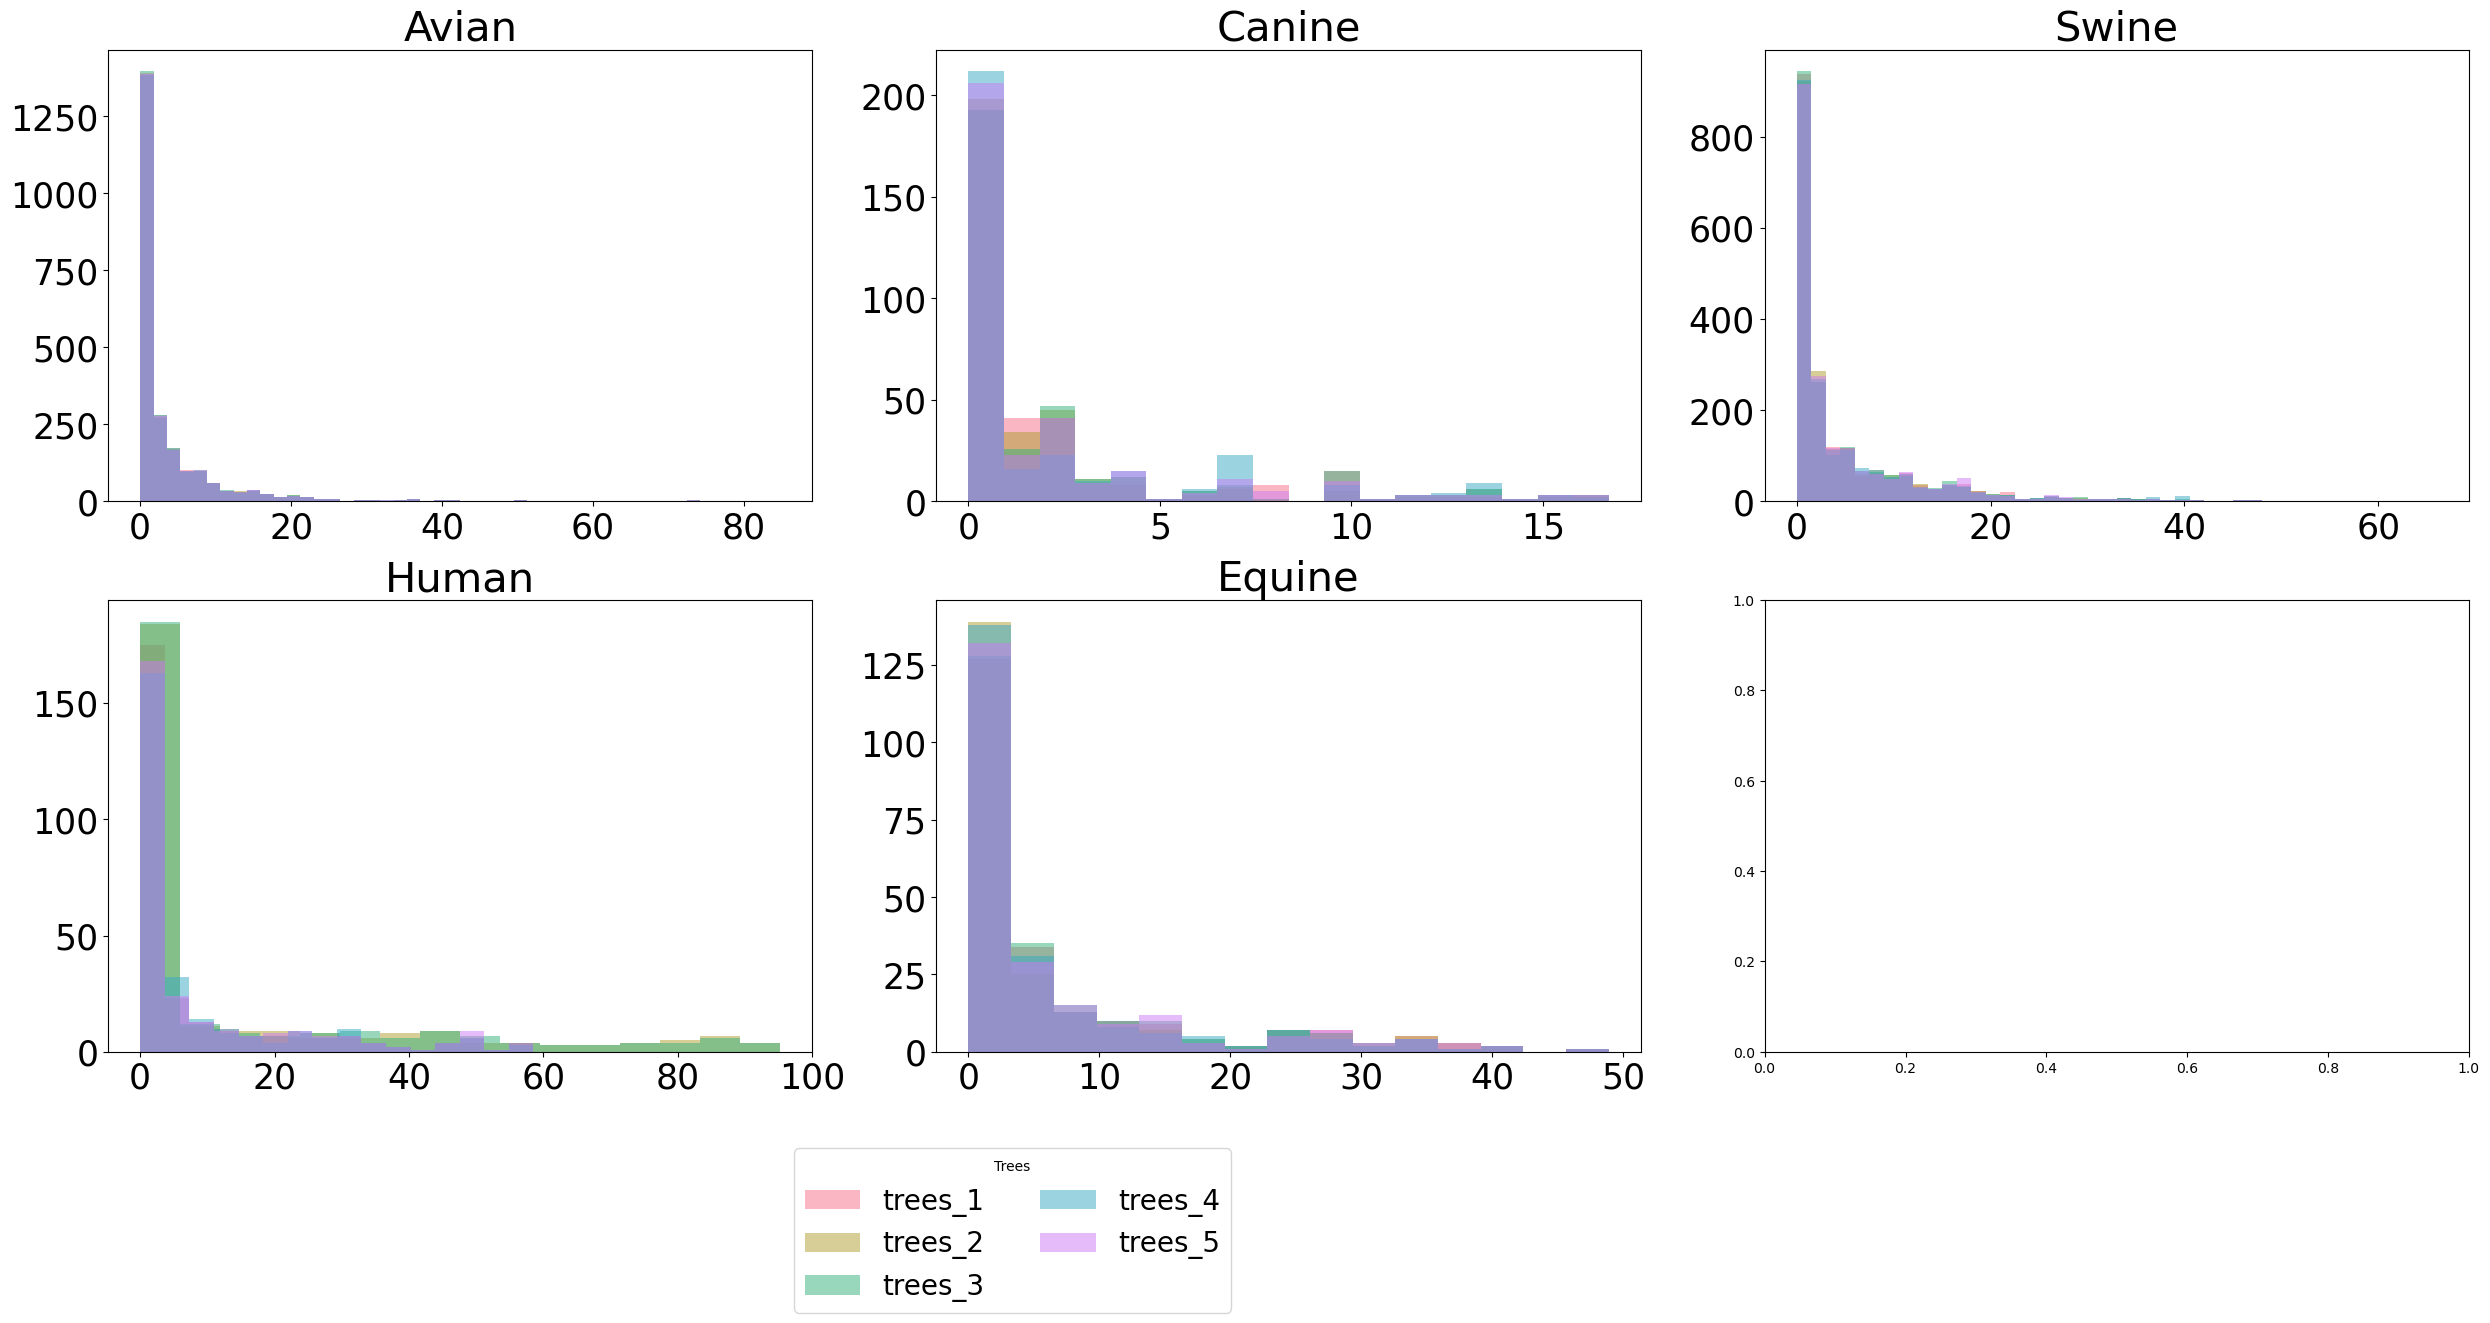

In [25]:
# using sqrt values for now
host_bins = {
    'Avian': 48,
    'Canine': 18,
    'Swine': 44,
    'Human': 16,
    'Equine': 15
}

hosts = list(dates_dist['trees_1'].keys())
tree_names = list(dates_dist.keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
axs = axs.flatten()

palette = sns.color_palette("husl", len(tree_names))

for i, host in enumerate(hosts):
    ax = axs[i]
    for j, tree in enumerate(tree_names):
        values = dates_dist[tree][host]
        ax.hist(
            values,
            bins=host_bins[host],
            alpha=0.5,
            color=palette[j],
            label=tree,
        )

    ax.set_title(host, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)
    ax.set_ylabel('')

fig.legend(tree_names, title="Trees", fontsize=20, loc='right', bbox_to_anchor=(0.5, -0.1), ncol=len(tree_names)//2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


##### bins set to 30 for all hosts:

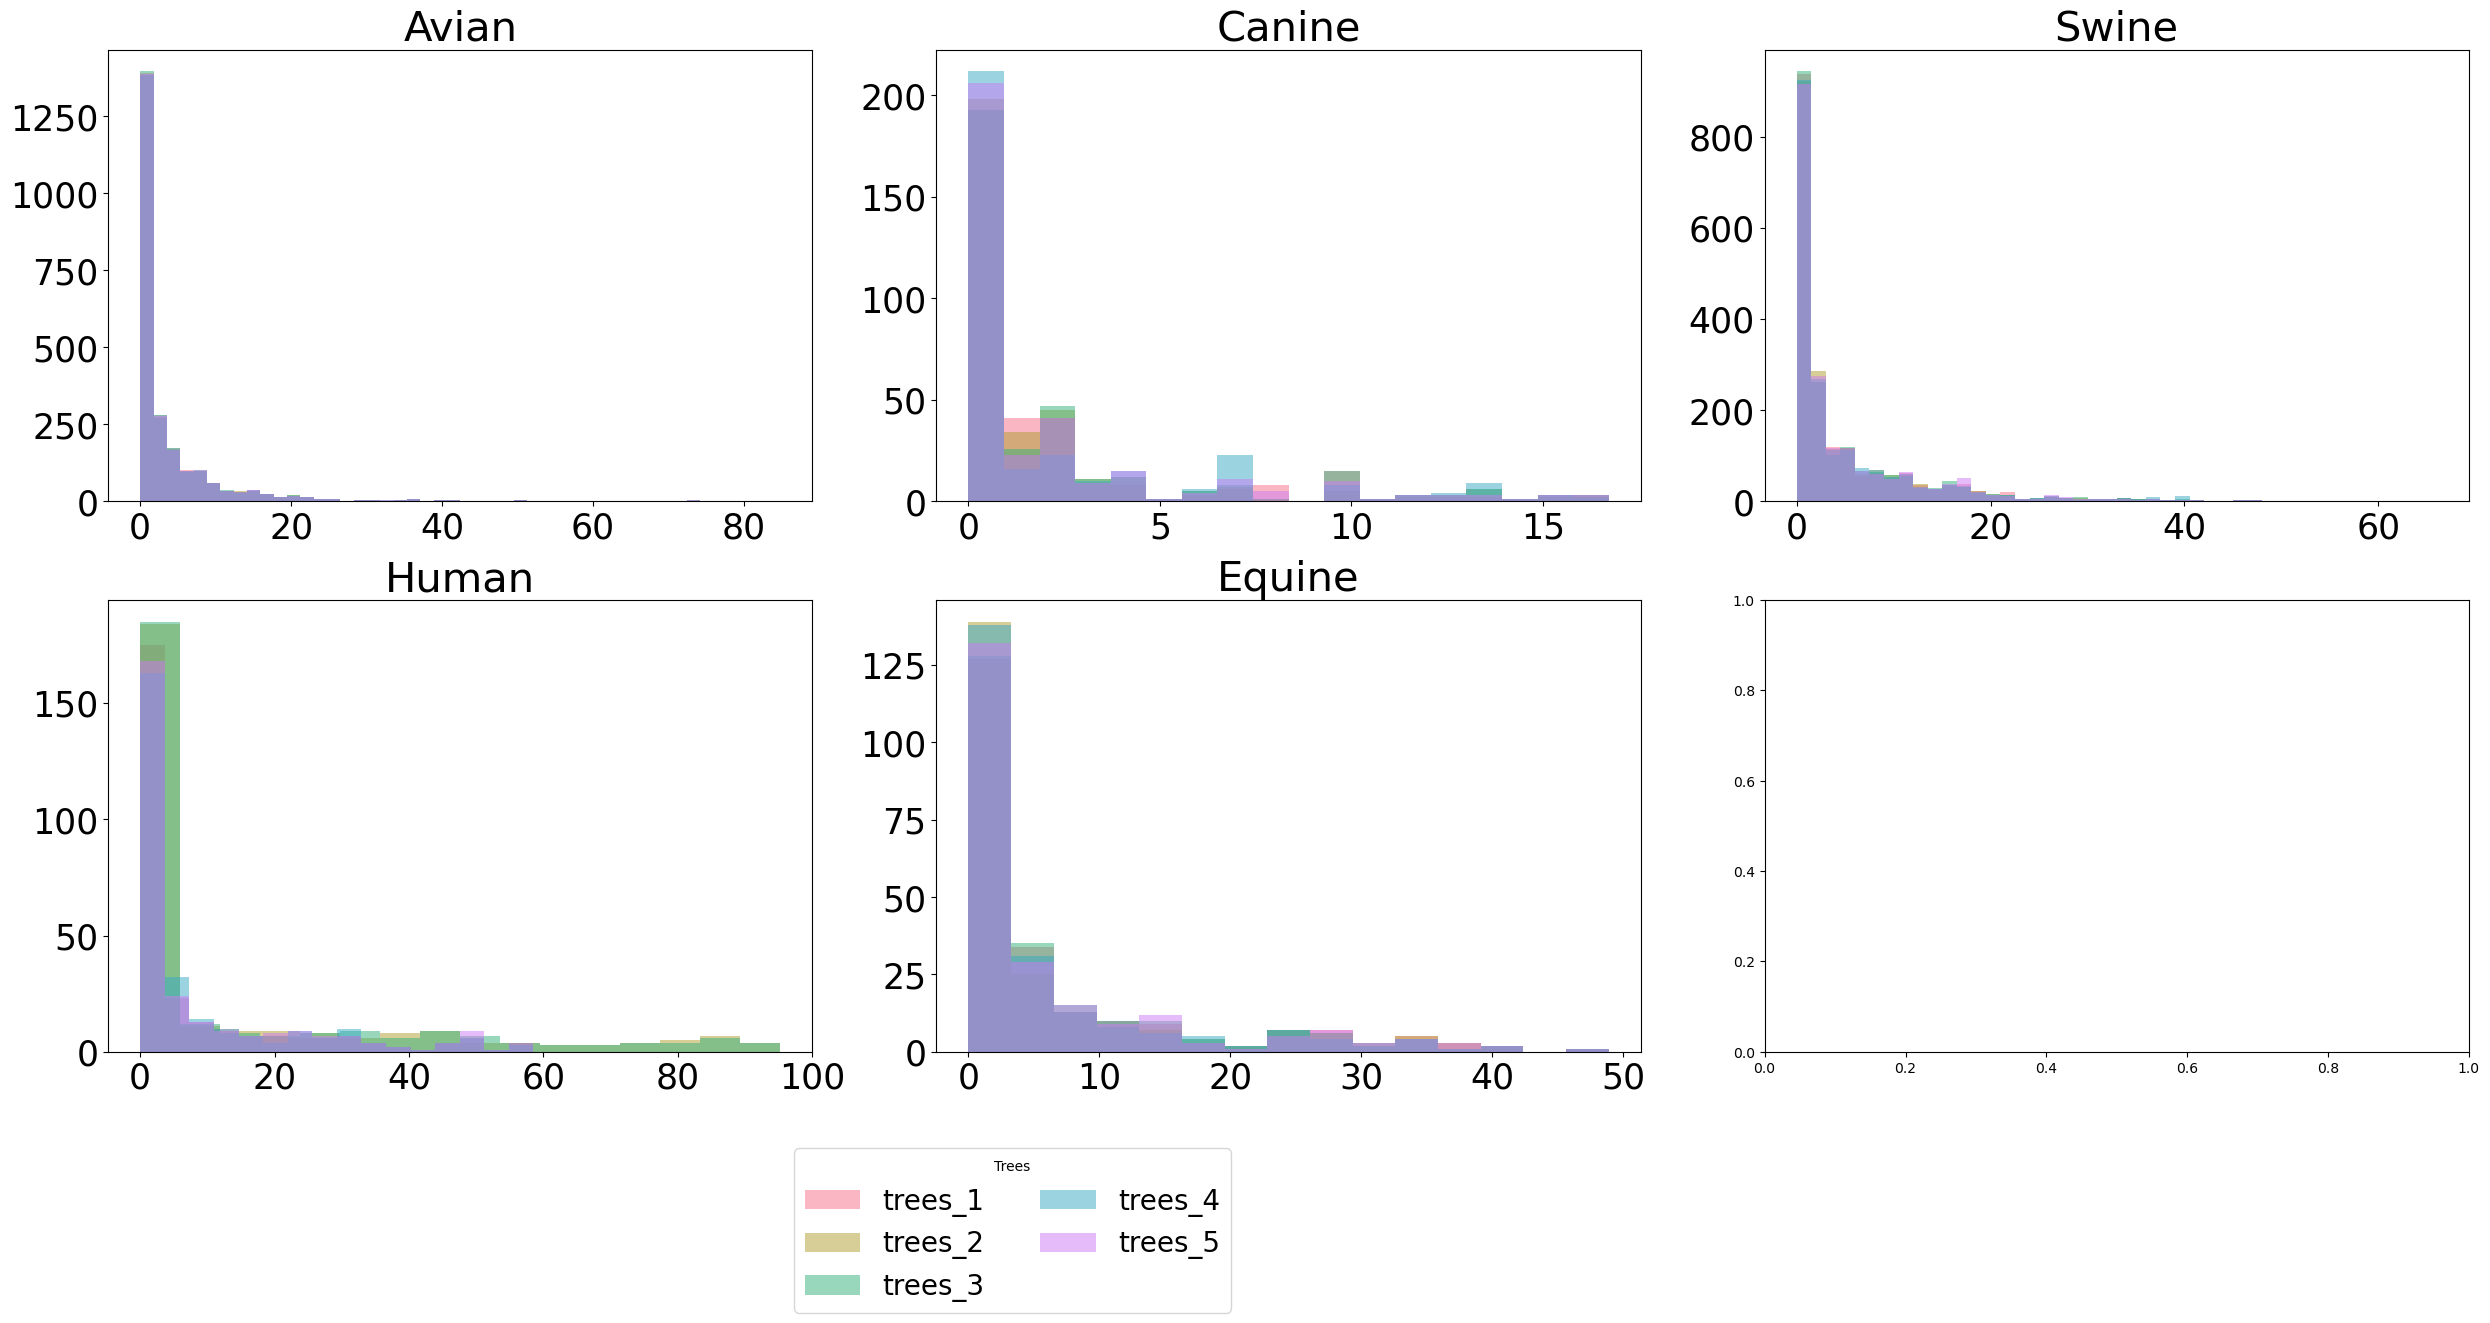

In [25]:
hosts = list(dates_dist['trees_1'].keys())
tree_names = list(dates_dist.keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12))
axs = axs.flatten()

palette = sns.color_palette("husl", len(tree_names))

for i, host in enumerate(hosts):
    ax = axs[i]
    for j, tree in enumerate(tree_names):
        values = dates_dist[tree][host]
        ax.hist(
            values,
            bins=30,
            alpha=0.5,
            color=palette[j],
            label=tree,
        )

    ax.set_title(host, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)
    ax.set_ylabel('')

fig.legend(tree_names, title="Trees", fontsize=20, loc='right', bbox_to_anchor=(0.5, -0.1), ncol=len(tree_names)//2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


### density function applied, stacked set to true

From matplotlib docs: 

When density is set to True, each bin will display the bin's raw count divided by the total number of counts and the bin width (density = counts / (sum(counts) * np.diff(bins))), so that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1).
If stacked is also True, the sum of the histograms is normalized to 1

##### using different bins for each host

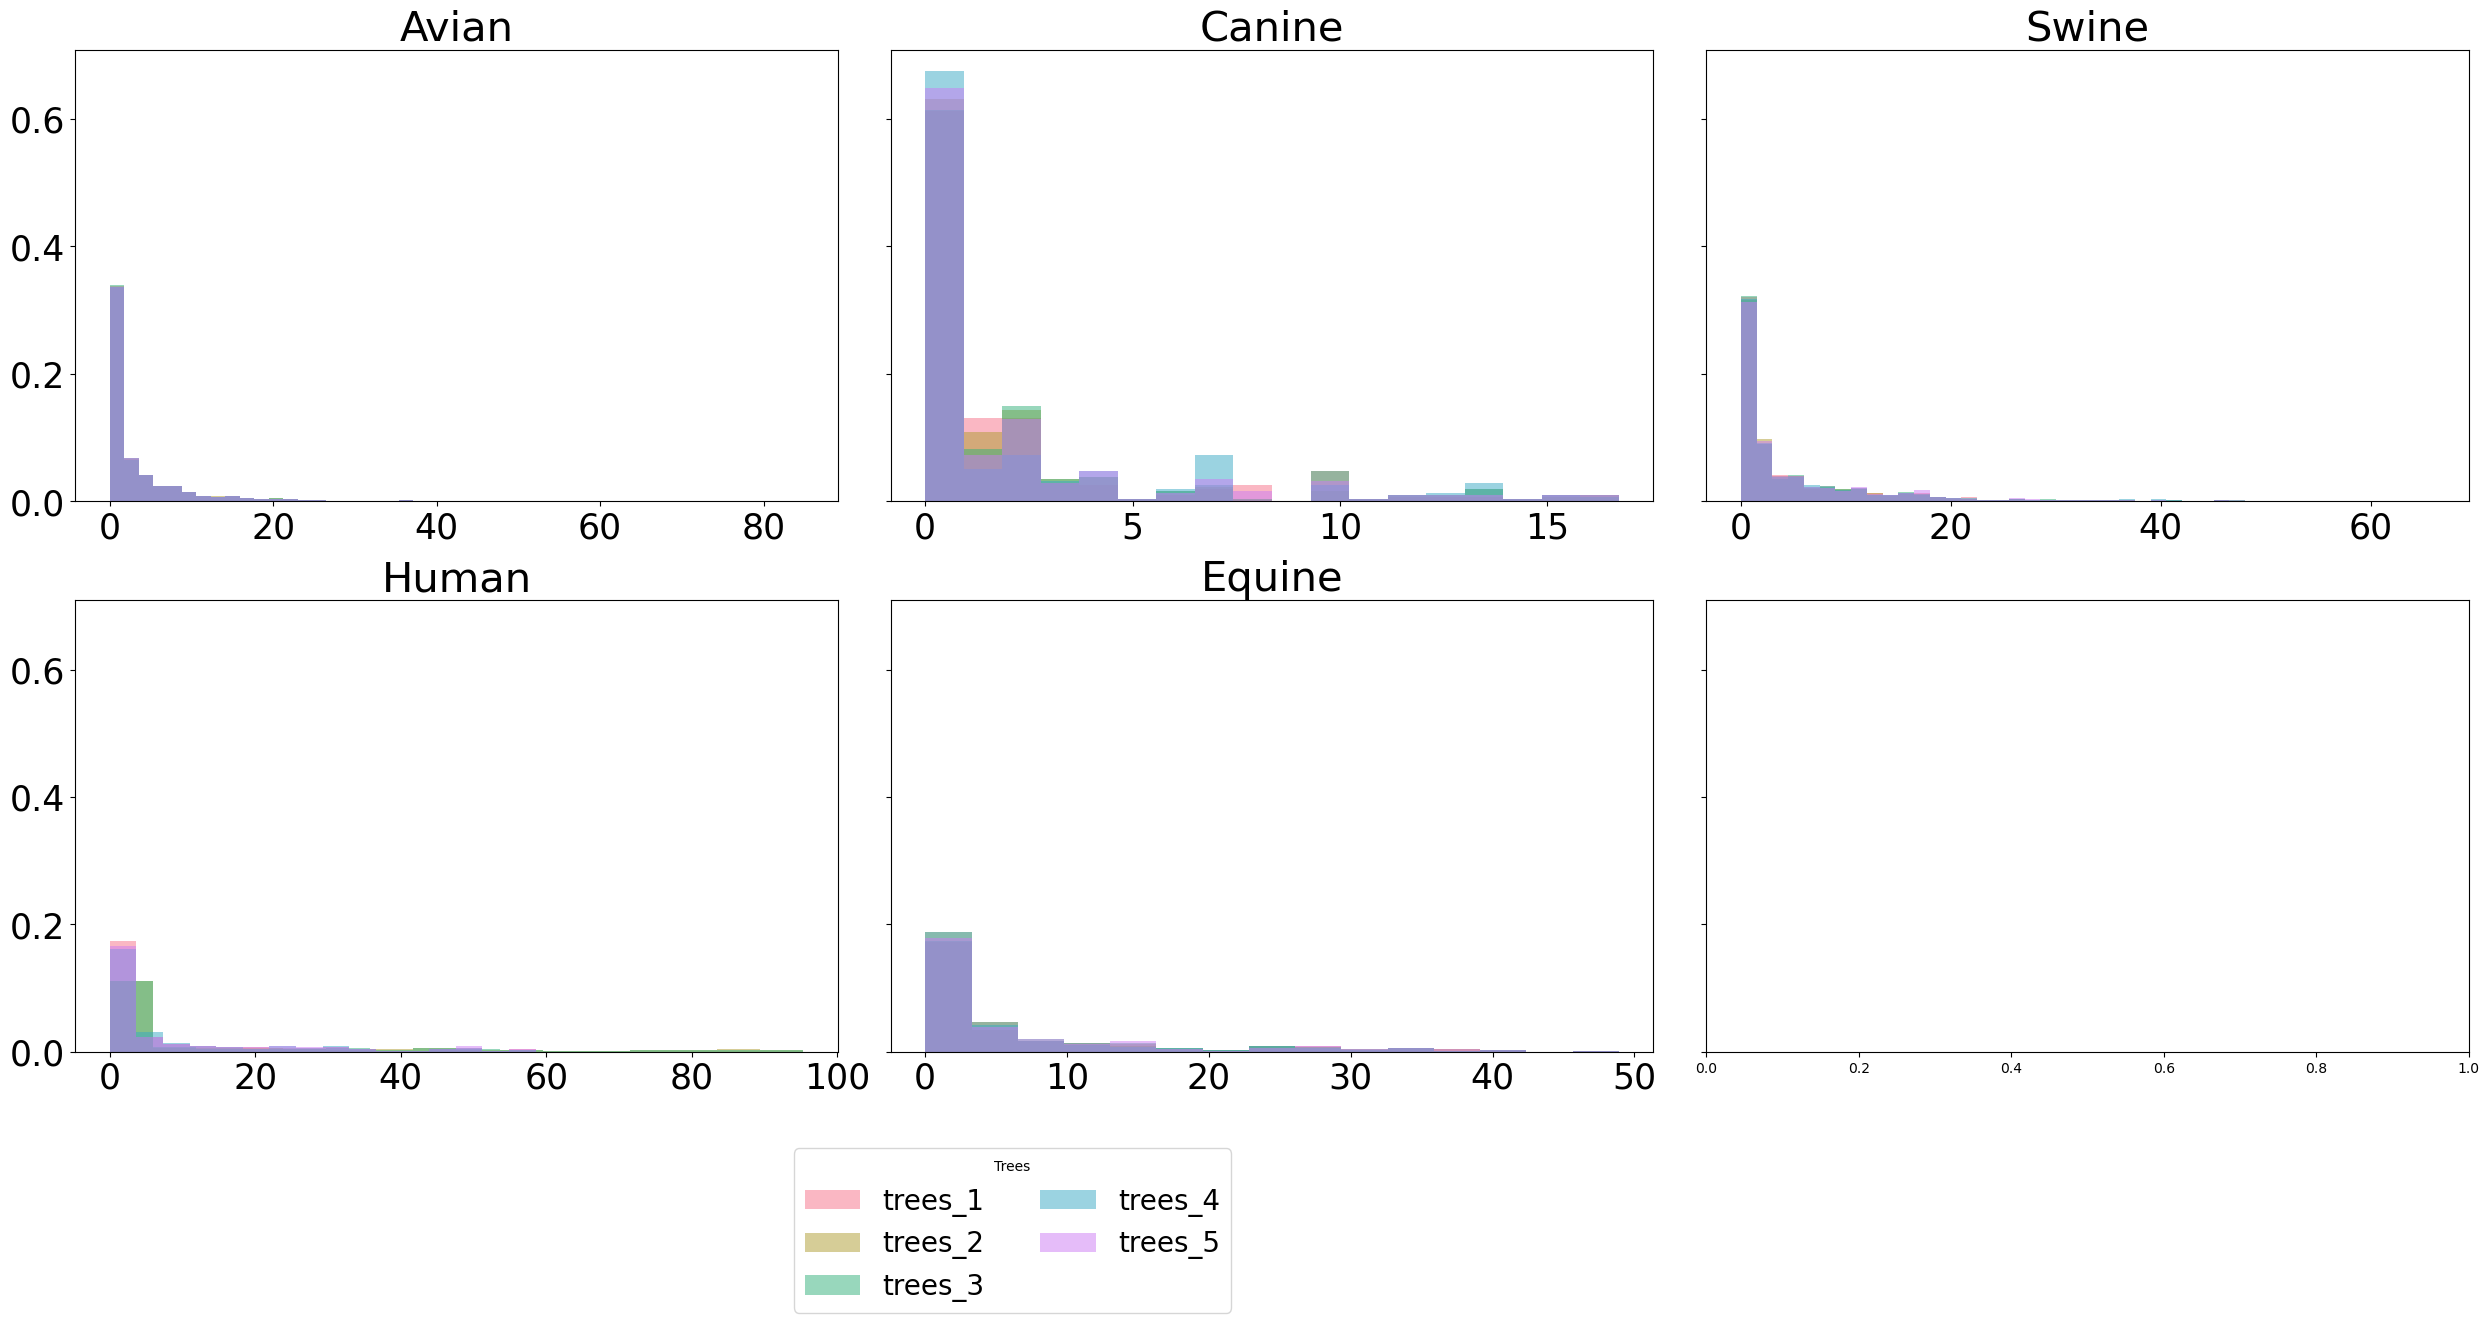

In [31]:
# using sqrt values for now
host_bins = {
    'Avian': 48,
    'Canine': 18,
    'Swine': 44,
    'Human': 16,
    'Equine': 15
}

hosts = list(dates_dist['trees_1'].keys())
tree_names = list(dates_dist.keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12), sharey = True)
axs = axs.flatten()

palette = sns.color_palette("husl", len(tree_names))

for i, host in enumerate(hosts):
    ax = axs[i]
    for j, tree in enumerate(tree_names):
        values = dates_dist[tree][host]
        ax.hist(
            values,
            bins=host_bins[host],
            alpha=0.5,
            color=palette[j],
            label=tree,
            density =True,
            stacked =True
        )

    ax.set_title(host, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)
    ax.set_ylabel('')

fig.legend(tree_names, title="Trees", fontsize=20, loc='right', bbox_to_anchor=(0.5, -0.1), ncol=len(tree_names)//2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


##### bins set to 30 for all hosts:

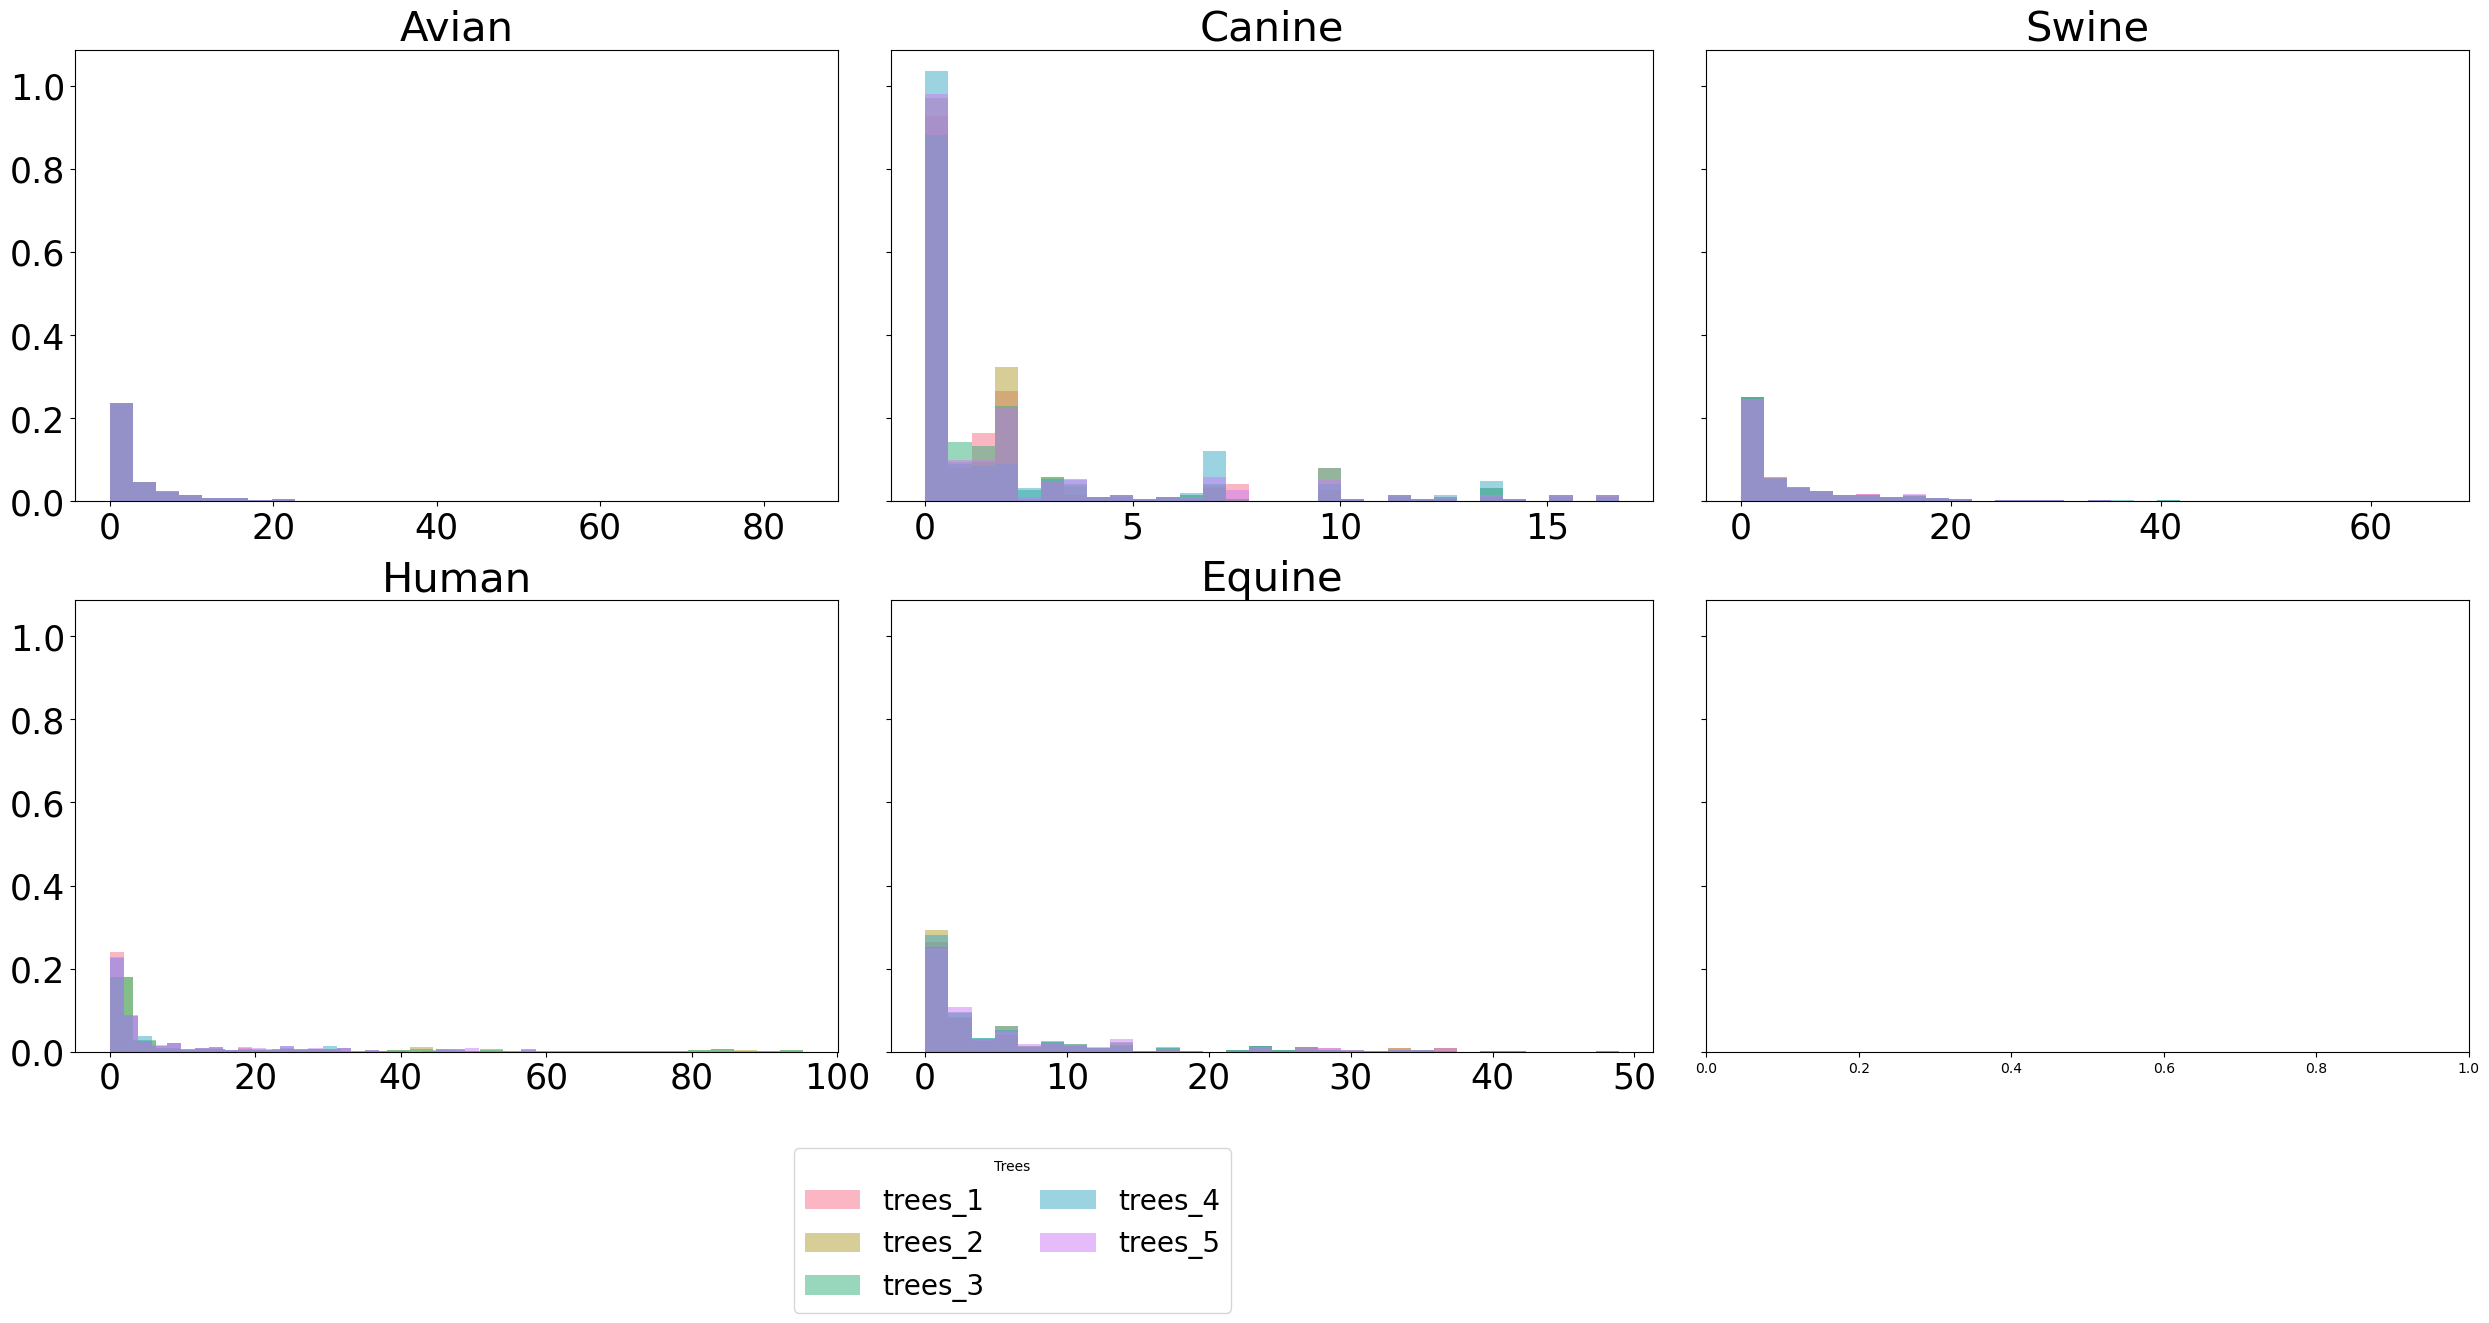

In [30]:
hosts = list(dates_dist['trees_1'].keys())
tree_names = list(dates_dist.keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12), sharey=True)
axs = axs.flatten()

palette = sns.color_palette("husl", len(tree_names))

for i, host in enumerate(hosts):
    ax = axs[i]
    for j, tree in enumerate(tree_names):
        values = dates_dist[tree][host]
        ax.hist(
            values,
            bins=30,  # or use dynamic binning like one of the rules
            alpha=0.5,
            color=palette[j],
            label=tree,
            density=True,
            stacked = True
        )

    ax.set_title(host, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)
    ax.set_ylabel('')

# Shared legend
fig.legend(tree_names, title="Trees", fontsize=20, loc='right', bbox_to_anchor=(0.5, -0.1), ncol=len(tree_names)//2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## KDE plotting

#### By replicate
reduced smoothing to shorten x-axis for human clade 

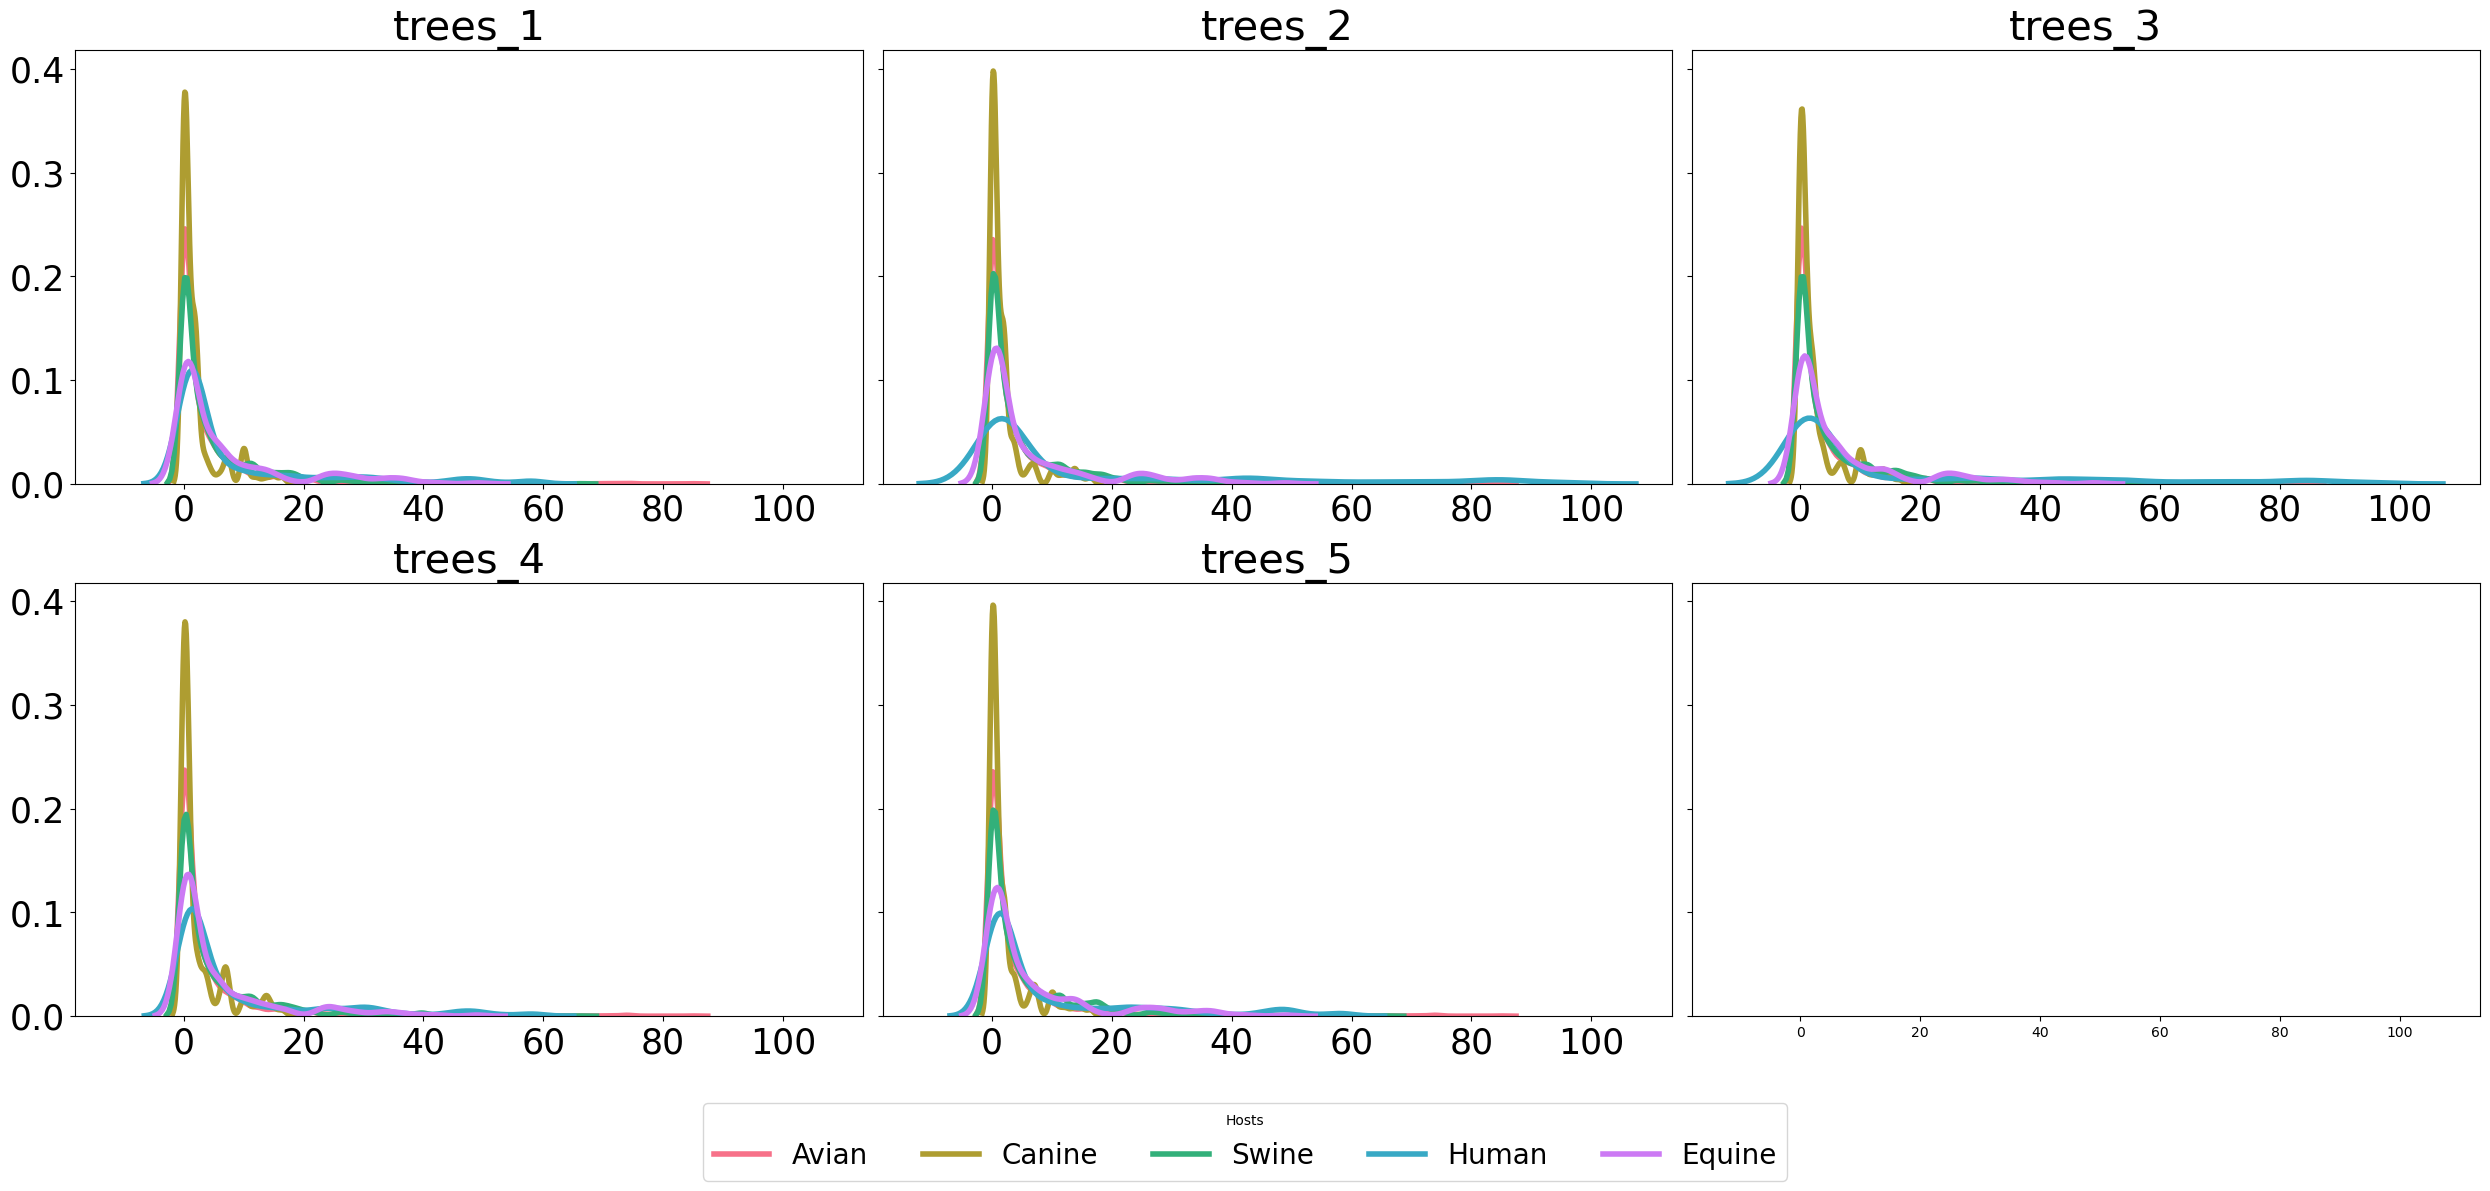

In [17]:
tree_names = list(dates_dist.keys())
hosts = list(dates_dist[tree_names[0]].keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12), sharey=True, sharex=True)
axs = axs.flatten()

palette = sns.color_palette("husl", len(hosts))

for i, tree in enumerate(tree_names):
    ax = axs[i]
    for j, host in enumerate(hosts):
        values = dates_dist[tree][host]
        sns.kdeplot(values, ax=ax, fill=False, linewidth=4, color=palette[j], label=host, bw_adjust=0.5)

    ax.set_title(tree, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)
    ax.set_ylabel('')

fig.legend(hosts, title="Hosts", fontsize=20, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(hosts))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


#### By host
reduced smoothing to shorten x-axis for human clade 

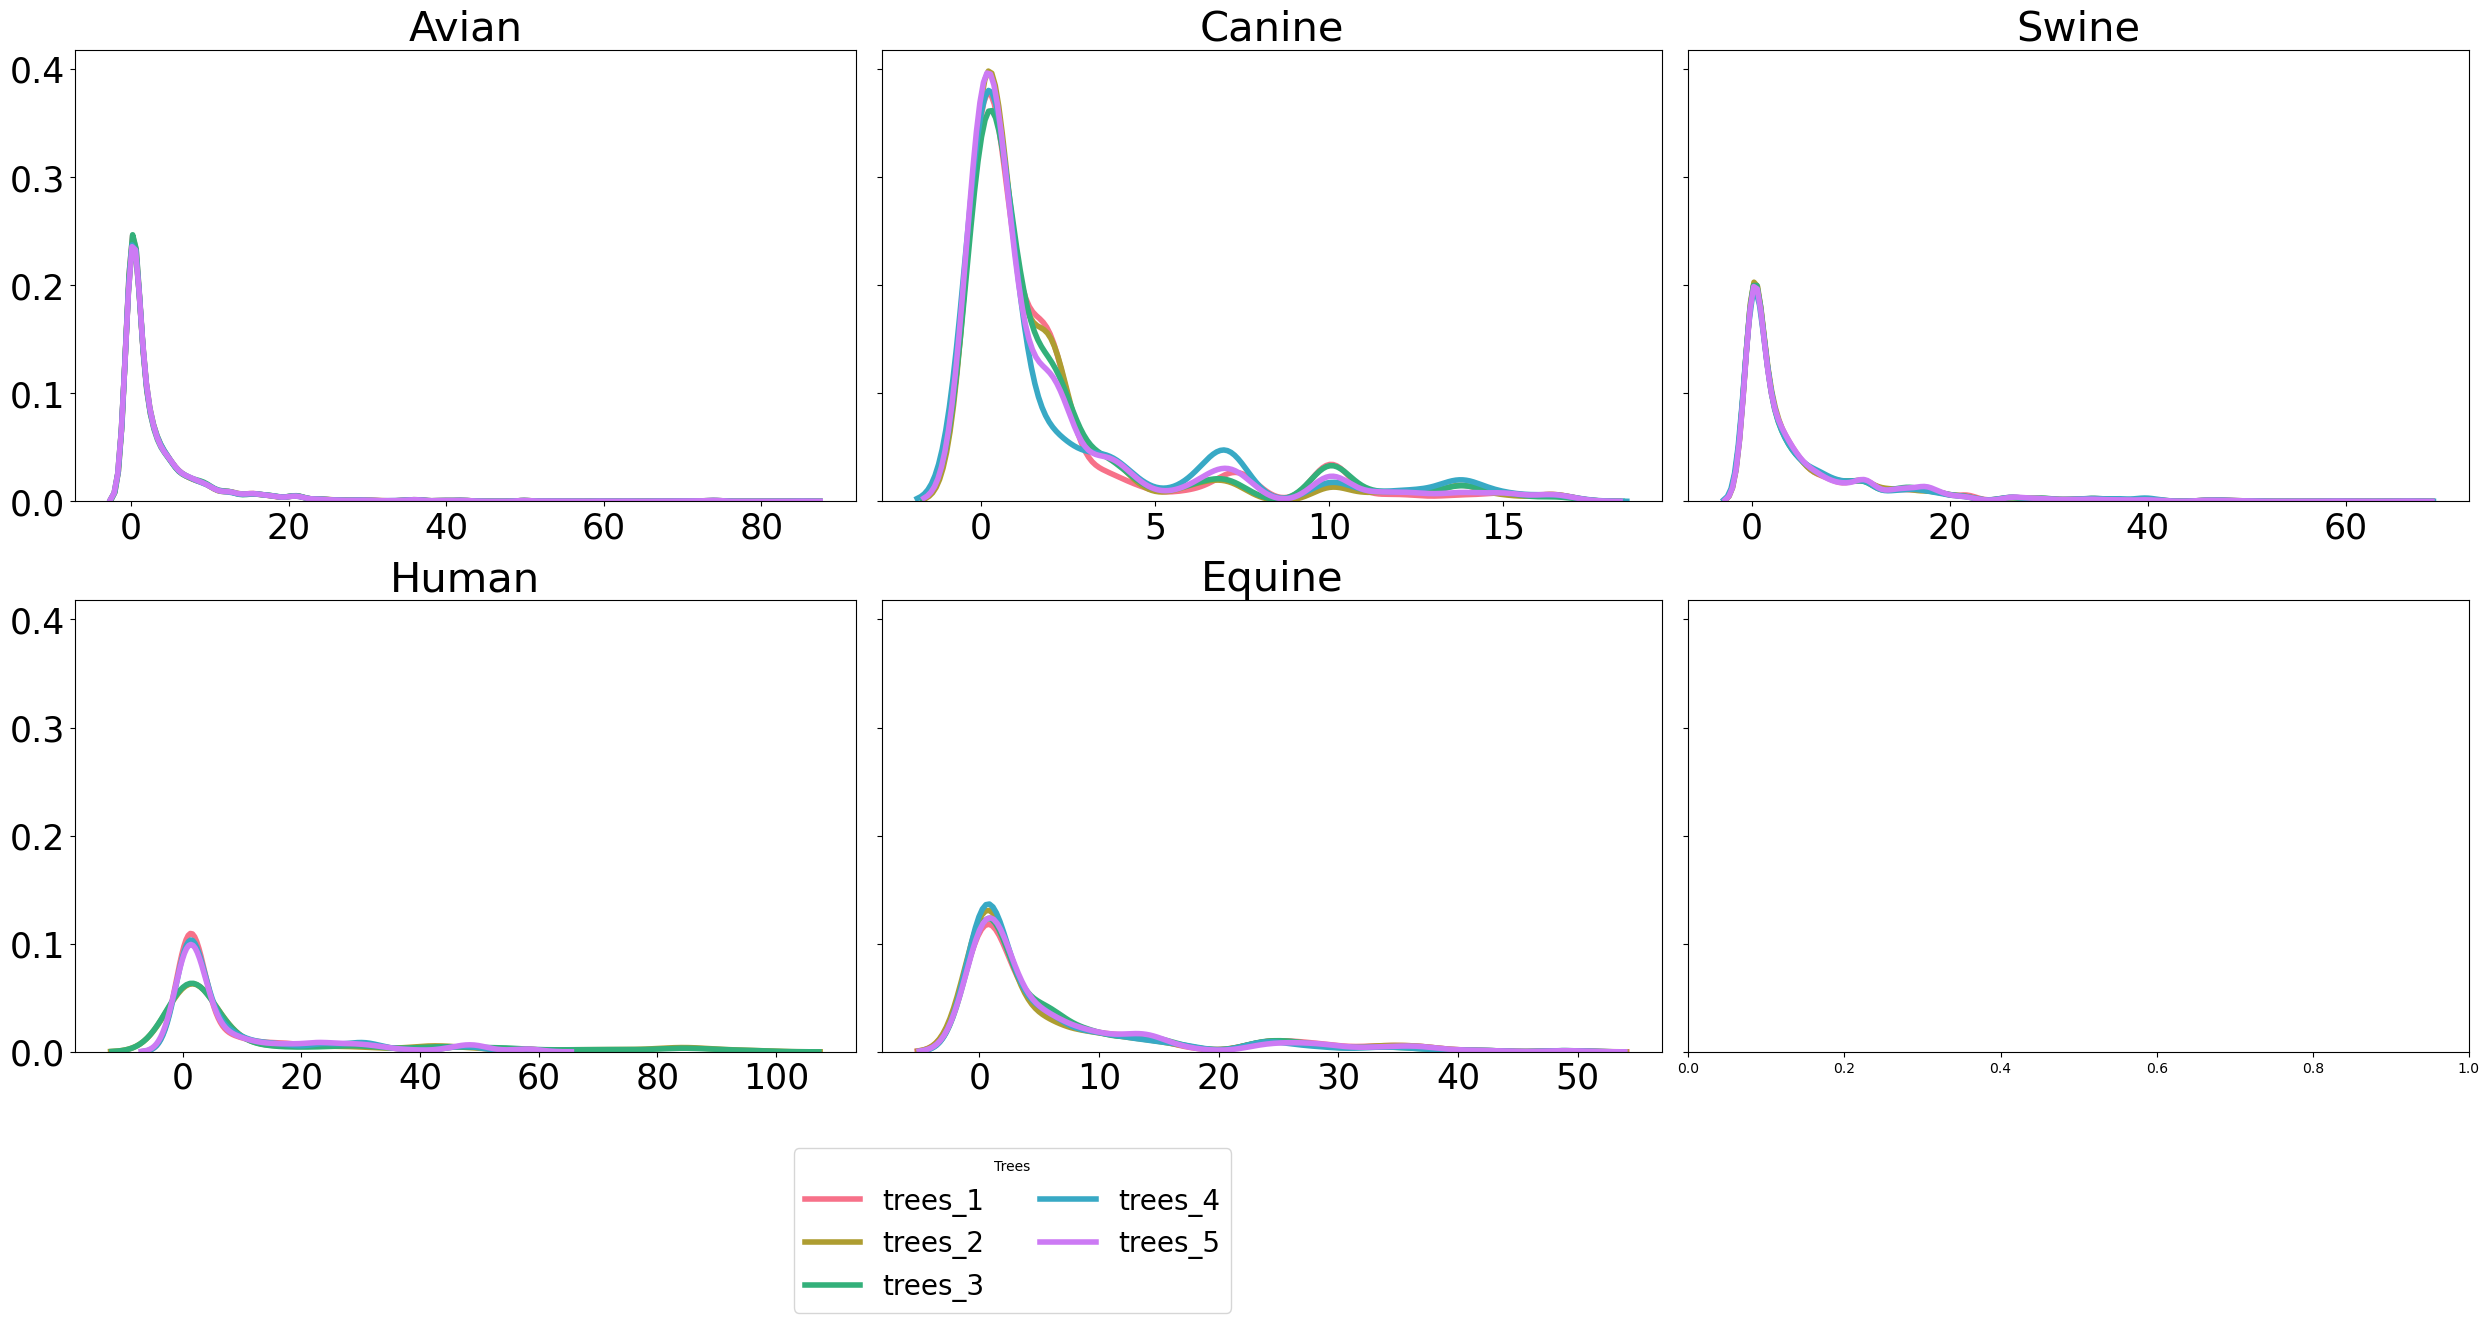

In [18]:
hosts = list(dates_dist['trees_1'].keys())
tree_names = list(dates_dist.keys())

fig, axs = plt.subplots(2, 3, figsize=(25, 12), sharey=True)
axs = axs.flatten()

palette = sns.color_palette("husl", len(tree_names))

for i, host in enumerate(hosts):
    ax = axs[i]
    for j, tree in enumerate(tree_names):
        values = dates_dist[tree][host]
        sns.kdeplot(values, ax=ax, fill=False, linewidth=4, color=palette[j], label=tree, bw_adjust=0.5)

    ax.set_title(host, fontsize=30)
    ax.tick_params(axis='both', labelsize=25)
    ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=25)

    ax.set_ylabel('')

fig.legend(tree_names, title="Trees", fontsize=20, loc='right', bbox_to_anchor=(0.5, -0.1), ncol=len(tree_names)//2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()